# Spreadsheet for advanced cannons #

Using data from https://fromthedepths.gamepedia.com/index.php?title=Advanced_Cannon&oldid=8383

In [1]:
from sympy import *
import math
from IPython.display import HTML, display
import ftd_calc as FTD
init_printing()

In [2]:
def formatValue(key, value):
    if key == 'diameter':
        return '{:3}'.format(math.floor(value*1000))
    if key == 'damage':
        damage_data = []
        for dtype, damage in value.items():
            if isinstance(damage, tuple) and len(damage) == 2:
                damage_data.append('{0}={1:3d}:{2:3.1f}'.format(dtype, int(damage[0]), damage[1]))
            else:
                damage_data.append('{0}={1}'.format(dtype, str(damage)))
        return '</br>'.join(damage_data)
    if isinstance(value, float):
        return '{: 3.2f}'.format(value)
    
    return str(value)

def displayTable(results, columns):
    # Row start - caption
    # Column - output variant
    # html = <table><tr><td>Name</td><td>Data1</td></tr></table>
    caption = '<td>{}</td>'.format('</td><td>'.join('<b>{}</b>'.format(str(key).upper()) for key in columns))
    rows = []
    for row in results:
        line = '</td><td>'.join(formatValue(key, row[key]) for key in columns)
        rows.append('<td>{}</td>'.format(line))
    
    htmlData = '</tr><tr>'.join(rows)
    return display(HTML('<table><tr>' + caption + '</tr><tr>' + htmlData + '</tr></table>'))

# AC #

In [3]:
diameter = symbols("D", positive=True)
numExplosive, modules, propellant, rail = symbols('Ne N Np Nr', positive=True)
charge = symbols("Q")

speedC = 1
kineticC = 1
railCharge = 0

In [4]:
context = {
    "diameter": 0.5, 
    "numExplosive": 0,
    "modules": modules,
    "propellant": propellant,
    "speedC": speedC,
    "kineticC": kineticC,
    "velCharge": Q,
    "rails": rail
}

DPS calculus example

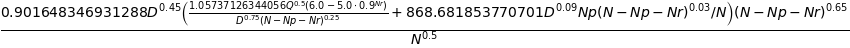

In [5]:
diameter = symbols("D", positive=True)
numExplosive, modules, propellant, rail = symbols('Ne N Np Nr', positive=True)
charge = symbols("Q")

data = FTD.calcWeaponDPS({
    "diameter": diameter, 
    "numExplosive": 0,
    "modules": modules,
    "propellant": propellant,
    "speedC": speedC,
    "kineticC": kineticC,
    "armorC": 1,
    "rails": rail,
    "loaders": 1,
    "clipsPerLoader": 3,
    "velCharge": charge
})
dps = data["dps"]
dps

Shell data:

DPS
>{{dps}}

Velocity = {{data}}

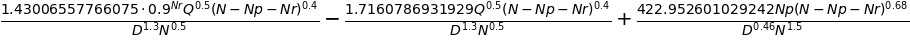

In [6]:
diff(expand(dps), diameter)

According to results, there are some situations when we get negative DPS if we fiddle with railguns

In [7]:
def checkResult(config):
    if config.get("velocity", 0)  < 50:
        return -1.0
    return config["dps"]

## Checking shell modifiers ##

In [8]:
shell_bp = ['apcap', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'rail', 'rail', 'rail']
FTD.calcSpeedMod(shell_bp)

In [9]:
FTD.calcKineticMod(shell_bp)

# Calculates the best shell for 1 and 2-loaders #
Will output 4 groups of variants

In [10]:
loaderSize = 1
batch = 4
results = FTD.calcBestShells(1, 4, batch, dict(loaders=1, clipsPerLoader=1, velCharge=0), checkResult)
results += FTD.calcBestShells(2, 4, batch, dict(loaders=1, clipsPerLoader=1, velCharge=0), checkResult)
results += FTD.calcBestShells(1, 16, batch, dict(loaders=1, clipsPerLoader=1, velCharge=1000), checkResult)
results += FTD.calcBestShells(2, 16, batch, dict(loaders=1, clipsPerLoader=1, velCharge=1000), checkResult)

In [11]:
displayTable(results, ["dps", "damage", "diameter", "velocity", "period", "shell"])

DPS,DAMAGE,DIAMETER,VELOCITY,PERIOD,SHELL
562.93,kinetic=8314:6.9,333,303.01,14.77,"['apcap', 'solid', 'gunpowder']"
604.78,kinetic=13399:8.8,500,489.69,22.16,"['apcap', 'gunpowder']"
605.86,kinetic=6711:14.1,250,503.29,11.08,"['apcap', 'bsabot', 'gunpowder', 'gunpowder']"
626.06,kinetic=6935:10.1,250,442.90,11.08,"['apcap', 'solid', 'gunpowder', 'gunpowder']"
789.32,kinetic=21746:9.1HE=2985:9.1,500,428.55,31.33,"['apcap', 'HE', 'gunpowder', 'gunpowder']"
838.23,kinetic=23491:10.3,500,523.32,28.02,"['apcap', 'bleeder', 'gunpowder', 'gunpowder']"
880.90,kinetic=27601:15.0,500,535.69,31.33,"['apcap', 'bsabot', 'gunpowder', 'gunpowder']"
910.27,kinetic=28521:10.8,500,471.41,31.33,"['apcap', 'solid', 'gunpowder', 'gunpowder']"
835.47,kinetic=5288:15.9,142,598.90,6.33,"['apcap', 'solid', 'solid', 'gunpowder', 'gunpowder', 'gunpowder', 'gunpowder']"
840.10,kinetic=6204:18.6,166,587.77,7.39,"['apcap', 'bsabot', 'solid', 'gunpowder', 'gunpowder', 'gunpowder']"


What do we see here:

 - Velocity is broken again
 - Kinetic damage is mostly accurate when velocity is accurate
 - HE damage is accurate
 - Reloading period is accurate
 - AP seems to be accurate when velocity is accurate

According to wiki:
>$AP=0.01av$

Some modules have maximum length, like bleeder.


In [12]:
real_data = {
    ('HE', 'gunpowder'): dict(D=0.5, T=22.16, velocity=326, ap=3.0, exp=2985, kin=2842),
    ('HE', 'HE', 'HE', 'gunpowder'): dict(D=0.5, velocity=169, ap=2.5, exp=6096, kin=6428),
    ('solid', 'solid', 'solid', 'gunpowder'): dict(D=0.5, velocity=219, ap=4.4, kin=16713),
    ('solid', 'solid', 'gunpowder', 'gunpowder'): dict(D=0.5, velocity=219, ap=4.4, kin=17760),
    ('HE', 'HE', 'gunpowder', 'gunpowder'): dict(D=0.5, T=31.33, velocity=333, ap=4.2, exp=4684, kin=7196),
    ('HE', 'HE', 'bleeder', 'gunpowder'): dict(D=0.5, T=28.7, velocity=257, ap=3.5, exp=4684, kin=6399),
    ('HE', 'gunpowder', 'gunpowder', 'gunpowder'): dict(D=0.5, velocity=490, ap=4.6, exp=2985, kin=4263)
}

We need to check whether value 0.01 is for AP is actual. Also we should calculate velocity error.

## Comparing with real results from FTD ##

This block was producing wrong **shellLength** and **length** values

In [13]:
shell_bp = ['HE', 'HE', 'bleeder', 'gunpowder']
shell = dict(diameter=0.5, velCharge=0, **FTD.calcBulletStats(shell_bp))
FTD.calcCannonData(shell)

{'accuracy': 0.5954583420518296,
 'armorC': 1.3783783783783783,
 'barrel_p': 8.0,
 'damage': {'HE': (4684.060743551104, 2.858241147914065),
  'kinetic': (6320.948563096364, 2.858241147914065)},
 'diameter': 0.5,
 'dps': 351.2290806906344,
 'expMod': 1.0,
 'kineticC': 2.0,
 'length': 2.0,
 'modules': 4,
 'numExplosive': 2,
 'period': 31.332853432887504,
 'propellant': 1,
 'shell': ['HE', 'HE', 'bleeder', 'gunpowder'],
 'shellLength': 1.5,
 'speedC': 1.229189189189189,
 'velCharge': 0,
 'velocity': 207.3625930839616,
 'vp': 207.3625930839616}

And this one is OK

In [14]:
shell = dict(shell=['HE', 'HE', 'bleeder', 'gunpowder'])
FTD.calcBulletLength(shell, diameter=0.5)
shell

{'diameter': 0.5,
 'length': 1.6,
 'shell': ['HE', 'HE', 'bleeder', 'gunpowder'],
 'shellLength': 1.1}

In [15]:
shell = FTD.calcBulletStats(['apcap', 'solid', 'gunpowder', 'gunpowder'], 0.5)
FTD.calcCannonData(dict(velCharge=1000, **shell))

{'accuracy': 0.628539361054709,
 'armorC': 2.2837837837837838,
 'barrel_p': 16.0,
 'coolers': 0.8167506081120626,
 'damage': {'kinetic': (31758.282901629802, 11.987787266147057)},
 'diameter': 0.5,
 'dps': 1013.5777441928018,
 'expMod': 1.0,
 'kineticC': 5.166666666666667,
 'length': 2.0,
 'modules': 4,
 'period': 31.332853432887504,
 'propellant': 2,
 'shell': ['apcap', 'solid', 'gunpowder', 'gunpowder'],
 'shellLength': 1.0,
 'speedC': 1.4142857142857144,
 'velCharge': 1000,
 'velocity': 524.9090282218239,
 'vp': 471.4070743410727,
 'vr': 53.50195388075111}

Slightly overestimated velocity, 525 vs 535

In [16]:
shell = FTD.calcBulletStats(['solid', 'solid', 'gunpowder'], 0.5)
FTD.calcCannonData(shell)

{'accuracy': 0.4465937565388722,
 'armorC': 1.635135135135135,
 'barrel_p': 8.0,
 'damage': {'kinetic': (11839.72474263173, 4.723508322476615)},
 'diameter': 0.5,
 'dps': 436.32593385922945,
 'expMod': 1.0,
 'kineticC': 3.5,
 'length': 1.5,
 'modules': 3,
 'period': 27.135047045935035,
 'propellant': 1,
 'shell': ['solid', 'solid', 'gunpowder'],
 'shellLength': 1.0,
 'speedC': 1.3000000000000003,
 'velocity': 288.87571558947894,
 'vp': 288.87571558947894}

In [17]:
1.3*1.1

In [18]:
shell = FTD.calcBulletStats(['HE', 'HE', 'HE', 'gunpowder'], 0.5)
FTD.calcCannonData(shell)

{'accuracy': 0.5954583420518296,
 'armorC': 1.5,
 'barrel_p': 8.0,
 'damage': {'HE': (6096.517668967417, 2.5304801926472886),
  'kinetic': (6427.965502269278, 2.5304801926472886)},
 'diameter': 0.5,
 'dps': 399.7236701746028,
 'expMod': 1.0,
 'kineticC': 2.5,
 'length': 2.0,
 'modules': 4,
 'numExplosive': 3,
 'period': 31.332853432887504,
 'propellant': 1,
 'shell': ['HE', 'HE', 'HE', 'gunpowder'],
 'shellLength': 1.5,
 'speedC': 1.0,
 'velocity': 168.69867950981924,
 'vp': 168.69867950981924}

In [19]:
shell = FTD.calcBulletStats(['solid', 'solid', 'solid', 'gunpowder'], 0.5)
FTD.calcCannonData(shell)

{'accuracy': 0.5954583420518296,
 'armorC': 2.0,
 'barrel_p': 8.0,
 'damage': {'kinetic': (16712.710305900127, 4.386165667255302)},
 'diameter': 0.5,
 'dps': 533.3925408899458,
 'expMod': 1.0,
 'kineticC': 5.0,
 'length': 2.0,
 'modules': 4,
 'period': 31.332853432887504,
 'propellant': 1,
 'shell': ['solid', 'solid', 'solid', 'gunpowder'],
 'shellLength': 1.5,
 'speedC': 1.3000000000000003,
 'velocity': 219.30828336276508,
 'vp': 219.30828336276508}

In [20]:
shell = FTD.calcBulletStats(['HE', 'HE', 'gunpowder', 'gunpowder'], 0.5)
FTD.calcCannonData(shell)

{'accuracy': 0.628539361054709,
 'armorC': 1.2567567567567568,
 'barrel_p': 16.0,
 'coolers': 0.8167506081120626,
 'damage': {'HE': (4684.060743551104, 4.188998162654085),
  'kinetic': (7155.877591700494, 4.188998162654085)},
 'diameter': 0.5,
 'dps': 377.87615994220926,
 'expMod': 1.0,
 'kineticC': 1.8333333333333333,
 'length': 2.0,
 'modules': 4,
 'numExplosive': 2,
 'period': 31.332853432887504,
 'propellant': 2,
 'shell': ['HE', 'HE', 'gunpowder', 'gunpowder'],
 'shellLength': 1.0,
 'speedC': 1.0,
 'velocity': 333.3181333724756,
 'vp': 333.3181333724756}

## This is the test for the shell generator ##

Should iterate every possible shell variant 

In [21]:
[a for a in FTD.allBodyGen(3)]

[['HE', 'rail'],
 ['HE', 'bleeder', 'rail'],
 ['HE', 'rail', 'rail'],
 ['HE', 'gunpowder'],
 ['HE', 'bleeder', 'gunpowder'],
 ['HE', 'gunpowder', 'rail'],
 ['HE', 'gunpowder', 'gunpowder'],
 ['HE', 'HE', 'rail'],
 ['HE', 'HE', 'gunpowder'],
 ['solid', 'rail'],
 ['solid', 'bleeder', 'rail'],
 ['solid', 'rail', 'rail'],
 ['solid', 'gunpowder'],
 ['solid', 'bleeder', 'gunpowder'],
 ['solid', 'gunpowder', 'rail'],
 ['solid', 'gunpowder', 'gunpowder'],
 ['solid', 'HE', 'rail'],
 ['solid', 'HE', 'gunpowder'],
 ['solid', 'solid', 'rail'],
 ['solid', 'solid', 'gunpowder'],
 ['bsabot', 'rail'],
 ['bsabot', 'bleeder', 'rail'],
 ['bsabot', 'rail', 'rail'],
 ['bsabot', 'gunpowder'],
 ['bsabot', 'bleeder', 'gunpowder'],
 ['bsabot', 'gunpowder', 'rail'],
 ['bsabot', 'gunpowder', 'gunpowder'],
 ['bsabot', 'HE', 'rail'],
 ['bsabot', 'HE', 'gunpowder'],
 ['bsabot', 'solid', 'rail'],
 ['bsabot', 'solid', 'gunpowder'],
 ['bsabot', 'bsabot', 'rail'],
 ['bsabot', 'bsabot', 'gunpowder'],
 ['composite', 'rai